# 生成验证码

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


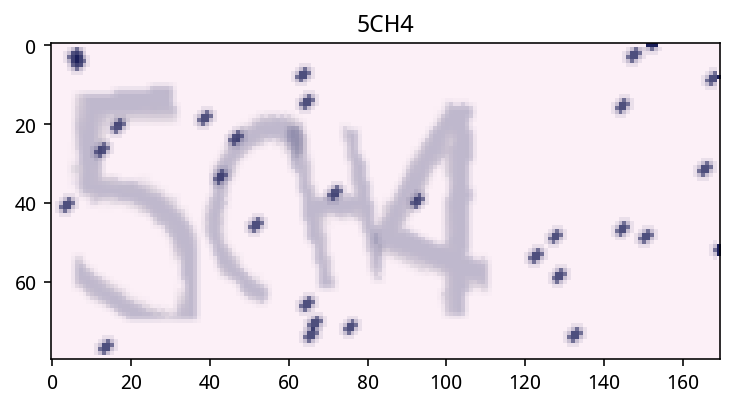

In [1]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
characters = string.digits + string.ascii_uppercase
print(characters)

width, height, n_len, n_class = 170, 80, 4, len(characters)+1

generator = ImageCaptcha(width=width, height=height)
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)

plt.imshow(img)
plt.title(random_str)

# 定义 CTC Loss

In [2]:
from keras import backend as K

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

Using TensorFlow backend.


# 构建模型

In [3]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
rnn_size = 128

input_tensor = Input((width, height, 3))
x = input_tensor
x = Lambda(lambda x:(x-127.5)/127.5)(x)
for i in range(3):
    for j in range(2):
        x = Conv2D(32*2**i, 3, kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

conv_shape = x.get_shape().as_list()
rnn_length = conv_shape[1]
rnn_dimen = conv_shape[2]*conv_shape[3]
print(conv_shape, rnn_length, rnn_dimen)
x = Reshape(target_shape=(rnn_length, rnn_dimen))(x)
rnn_length -= 2

x = Dense(rnn_size, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)

gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_uniform', name='gru1')(x)
gru_1b = GRU(rnn_size, return_sequences=True, kernel_initializer='he_uniform', 
             go_backwards=True, name='gru1_b')(x)
x = add([gru_1, gru_1b])

gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_uniform', name='gru2')(x)
gru_2b = GRU(rnn_size, return_sequences=True, kernel_initializer='he_uniform', 
             go_backwards=True, name='gru2_b')(x)
x = concatenate([gru_2, gru_2b])

x = Dropout(0.2)(x)
x = Dense(n_class, activation='softmax')(x)
base_model = Model(inputs=input_tensor, outputs=x)

labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), 
                  name='ctc')([x, labels, input_length, label_length])

model = Model(inputs=[input_tensor, labels, input_length, label_length], outputs=[loss_out])
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')

([None, 17, 6, 128], 17, 768)


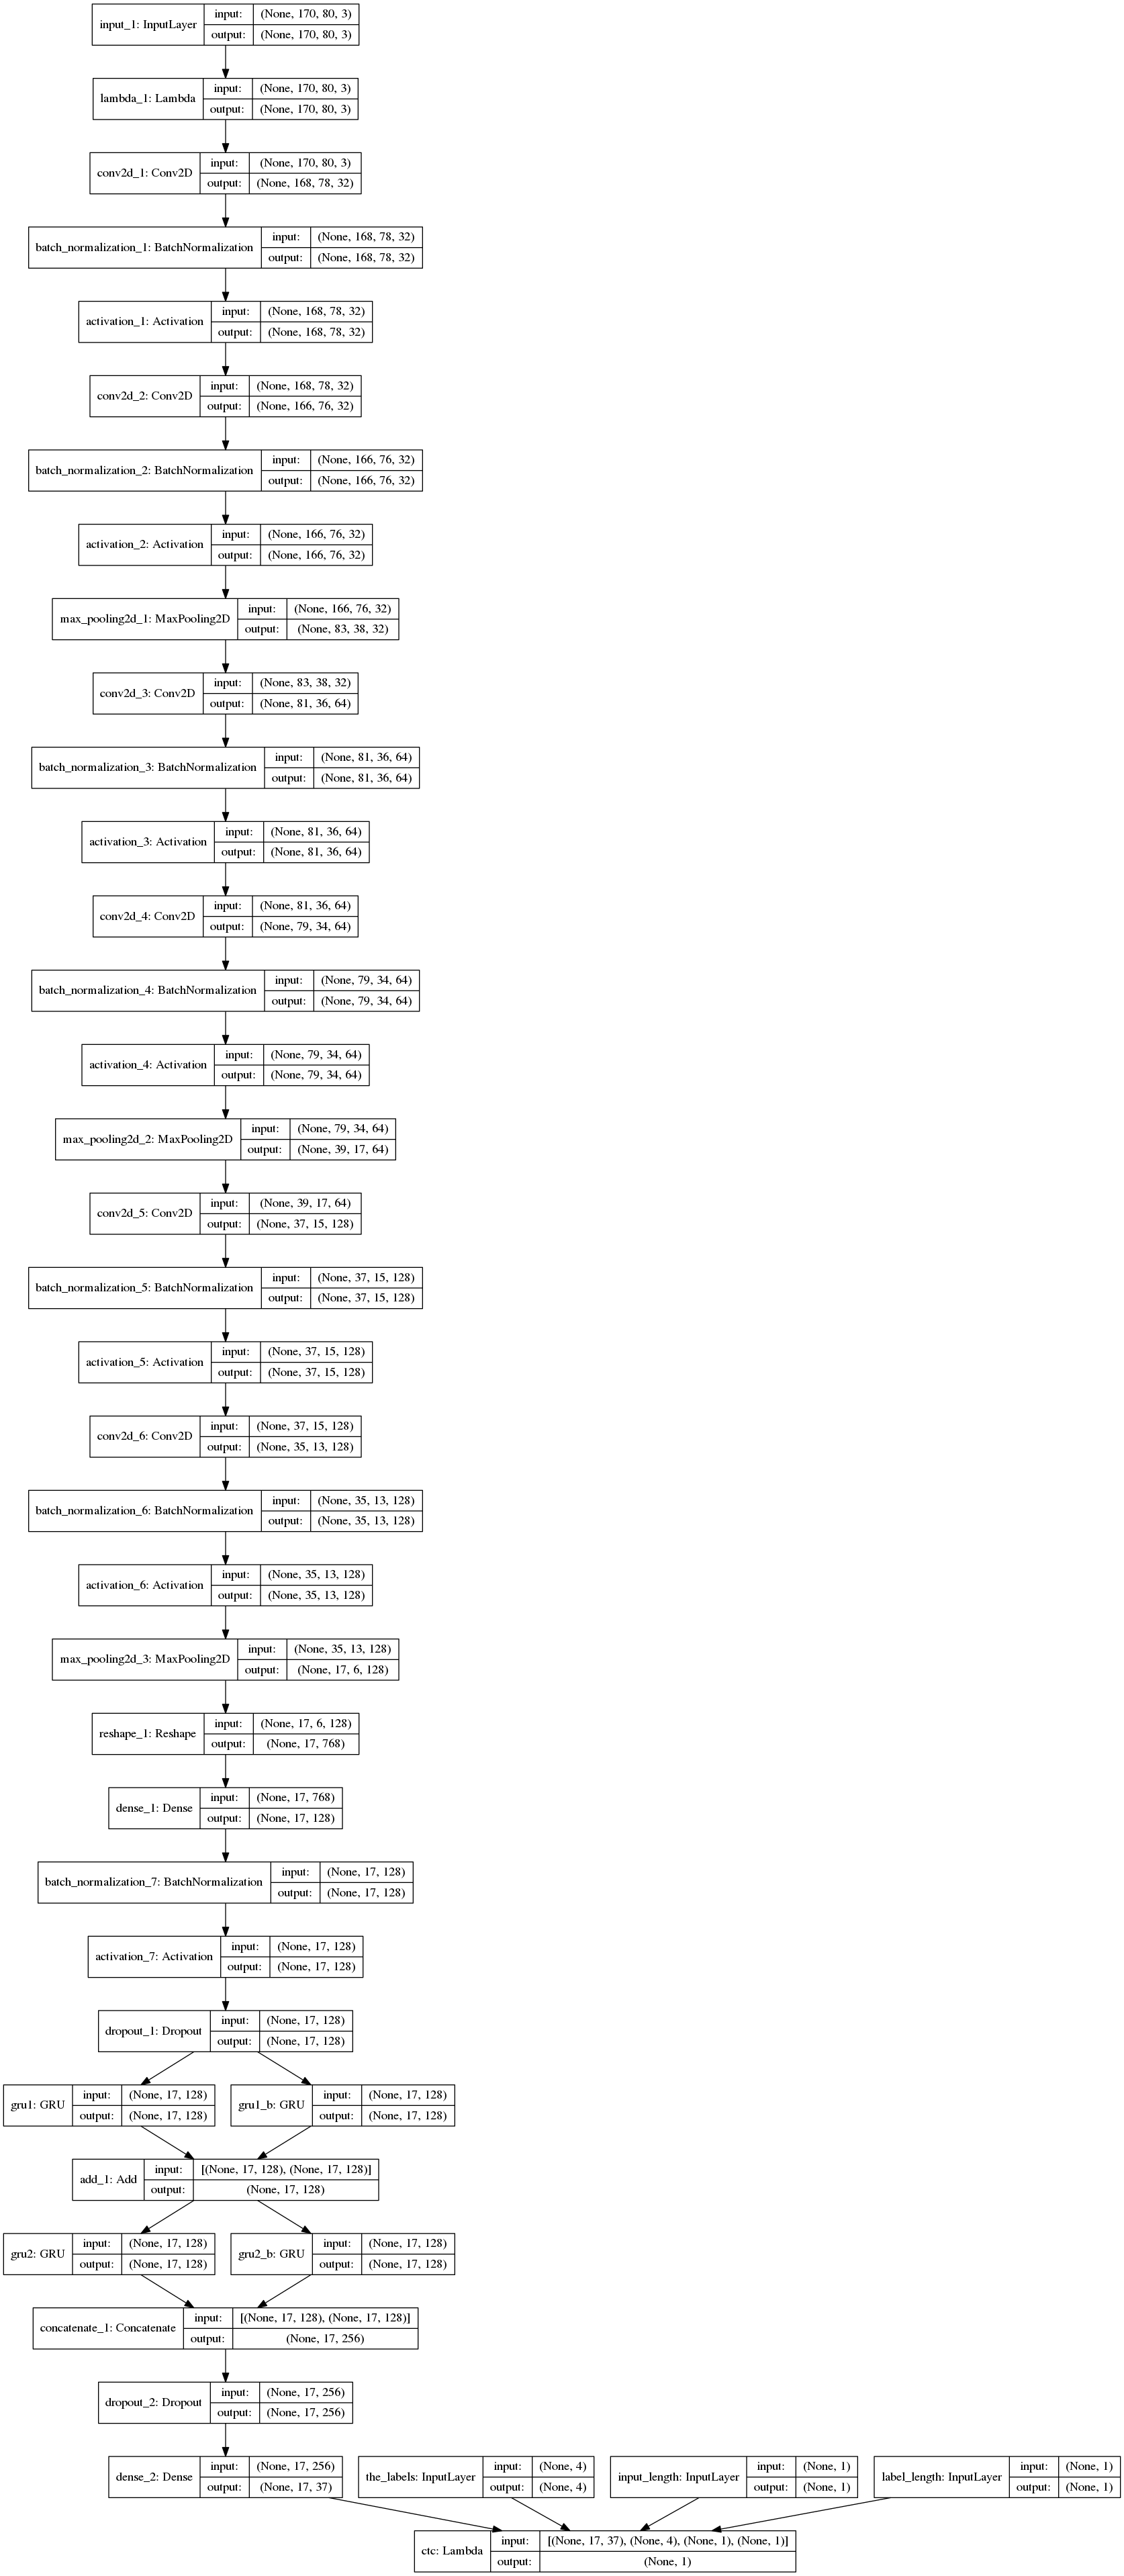

In [4]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(model, to_file="model.png", show_shapes=True)
Image('model.png')

In [5]:
def gen(batch_size=128):
    X = np.zeros((batch_size, width, height, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.uint8)
    generator = ImageCaptcha(width=width, height=height)
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(n_len)])
            X[i] = np.array(generator.generate_image(random_str)).transpose(1, 0, 2)
            y[i] = [characters.find(x) for x in random_str]
        yield [X, y, np.ones(batch_size)*rnn_length, np.ones(batch_size)*n_len], np.ones(batch_size)

((1, 170, 80, 3), array([[12,  1,  8,  7]], dtype=uint8), array([ 15.]), array([ 4.]))


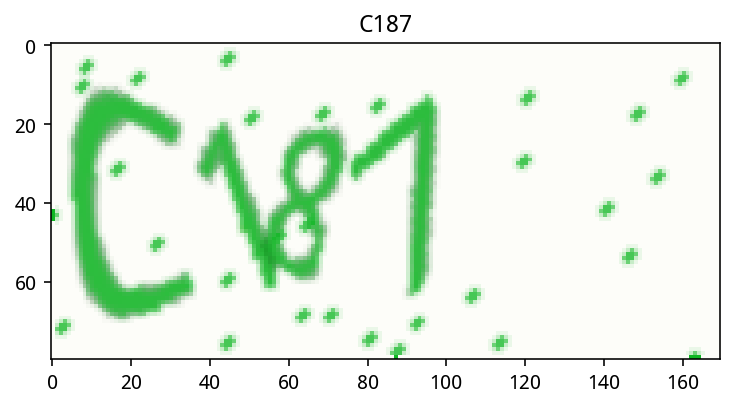

In [6]:
(X_vis, y_vis, input_length_vis, label_length_vis), _ = next(gen(1))
print(X_vis.shape, y_vis, input_length_vis, label_length_vis)

plt.imshow(X_vis[0].transpose(1, 0, 2))
plt.title(''.join([characters[i] for i in y_vis[0]]))

In [7]:
def evaluate(batch_size=128, steps=10):
    batch_acc = 0
    generator = gen(batch_size)
    for i in range(steps):
        [X_test, y_test, _, _], _  = next(generator)
        y_pred = base_model.predict(X_test)
        shape = y_pred[:,2:,:].shape
        ctc_decode = K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0]
        out = K.get_value(ctc_decode)[:, :n_len]
        if out.shape[1] == n_len:
            batch_acc += (y_test == out).all(axis=1).mean()
    return batch_acc / steps

In [8]:
from keras.callbacks import *

class Evaluator(Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        acc = evaluate(steps=20)*100
        self.accs.append(acc)
        print('')
        print('acc: %f%%' % acc)

evaluator = Evaluator()

In [9]:
h = model.fit_generator(gen(128), steps_per_epoch=400, epochs=20,
                        callbacks=[evaluator],
                        validation_data=gen(128), validation_steps=20)

Epoch 1/20
399/400 [============================>.] - ETA: 0s - loss: 5.0689
acc: 68.984375%
400/400 [==============================] - 125s - loss: 5.0581 - val_loss: 1.4271
Epoch 2/20
399/400 [============================>.] - ETA: 0s - loss: 0.4020
acc: 72.343750%
400/400 [==============================] - 120s - loss: 0.4016 - val_loss: 1.2555
Epoch 3/20
399/400 [============================>.] - ETA: 0s - loss: 0.3102
acc: 90.312500%
400/400 [==============================] - 120s - loss: 0.3098 - val_loss: 0.4019
Epoch 4/20
399/400 [============================>.] - ETA: 0s - loss: 0.2906
acc: 95.078125%
400/400 [==============================] - 121s - loss: 0.2902 - val_loss: 0.2684
Epoch 5/20
399/400 [============================>.] - ETA: 0s - loss: 0.2452
acc: 94.609375%
400/400 [==============================] - 120s - loss: 0.2454 - val_loss: 0.2778
Epoch 6/20
399/400 [============================>.] - ETA: 0s - loss: 0.3524
acc: 93.710938%
400/400 [=======================

In [10]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(1e-4))
h2 = model.fit_generator(gen(128), steps_per_epoch=400, epochs=20, 
                        callbacks=[evaluator],
                        validation_data=gen(128), validation_steps=20)

Epoch 1/20
399/400 [============================>.] - ETA: 0s - loss: 0.2262
acc: 98.789062%
400/400 [==============================] - 121s - loss: 0.2257 - val_loss: 0.1465
Epoch 2/20
399/400 [============================>.] - ETA: 0s - loss: 0.1593
acc: 98.828125%
400/400 [==============================] - 120s - loss: 0.1591 - val_loss: 0.1196
Epoch 3/20
399/400 [============================>.] - ETA: 0s - loss: 0.1542
acc: 99.062500%
400/400 [==============================] - 121s - loss: 0.1539 - val_loss: 0.1745
Epoch 4/20
399/400 [============================>.] - ETA: 0s - loss: 0.1680
acc: 99.062500%
400/400 [==============================] - 122s - loss: 0.1677 - val_loss: 0.1950
Epoch 5/20
399/400 [============================>.] - ETA: 0s - loss: 0.2337
acc: 98.906250%
400/400 [==============================] - 123s - loss: 0.2331 - val_loss: 0.0965
Epoch 6/20
399/400 [============================>.] - ETA: 0s - loss: 0.1449
acc: 99.453125%
400/400 [=======================

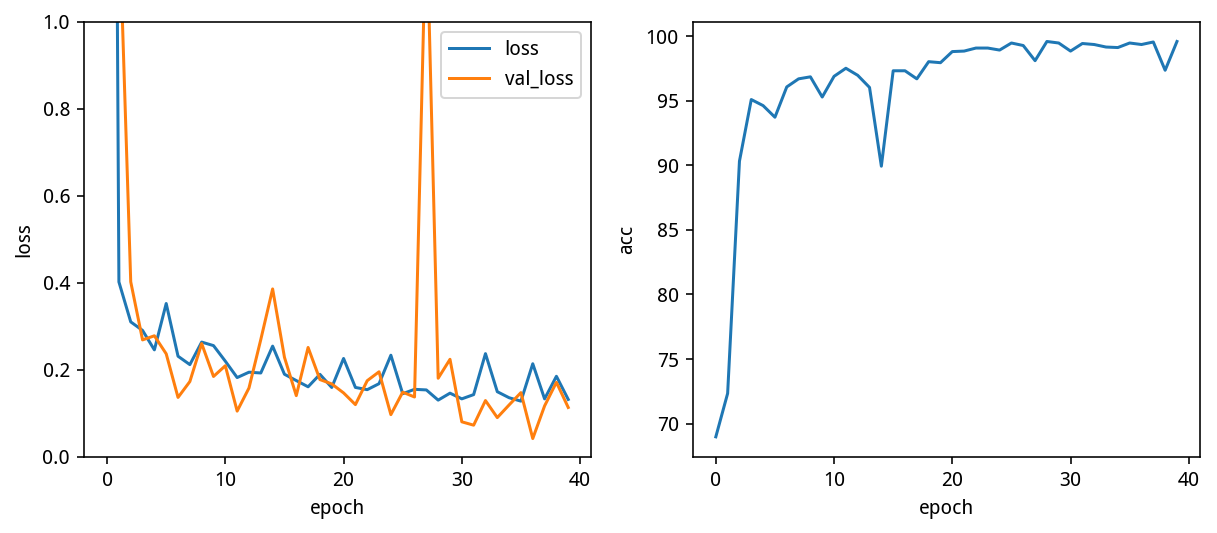

In [11]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'] + h2.history['loss'])
plt.plot(h.history['val_loss'] + h2.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.plot(evaluator.accs)
plt.ylabel('acc')
plt.xlabel('epoch')

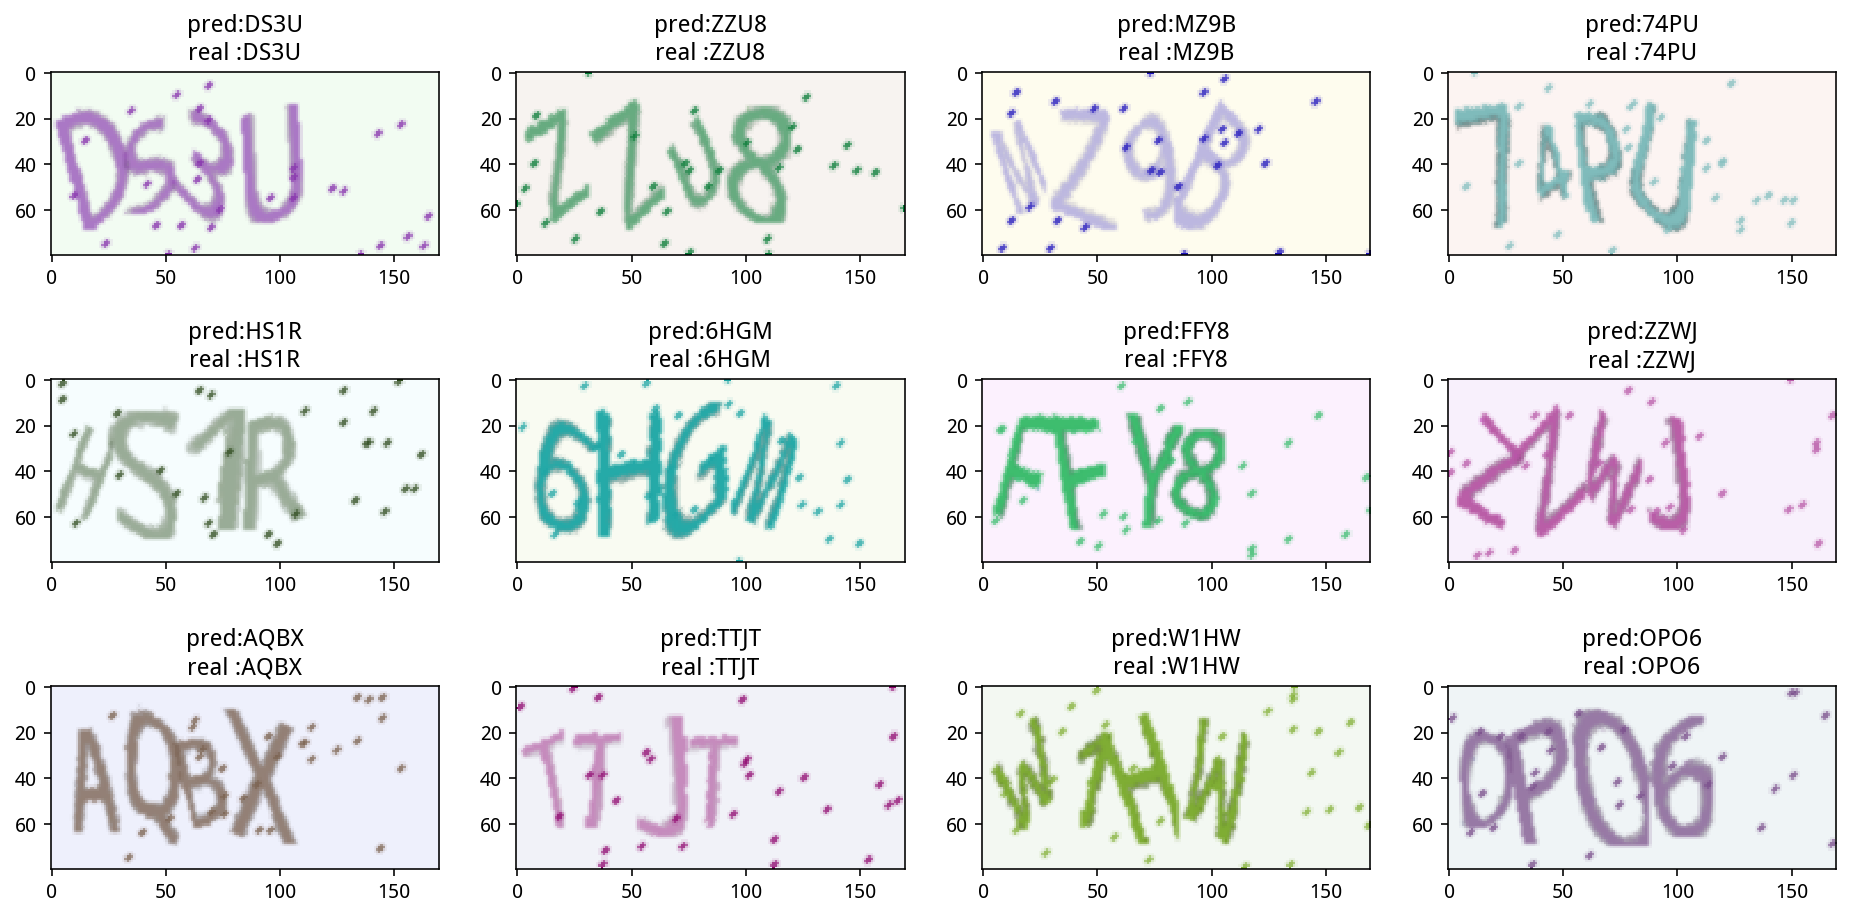

In [12]:
(X_vis, y_vis, input_length_vis, label_length_vis), _ = next(gen(12))

y_pred = base_model.predict(X_vis)
shape = y_pred[:,2:,:].shape
ctc_decode = K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0]
out = K.get_value(ctc_decode)[:, :4]

plt.figure(figsize=(16, 8))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(X_vis[i].transpose(1, 0, 2))
    plt.title('pred:%s\nreal :%s' % (''.join([characters[x] for x in out[i]]), 
                                     ''.join([characters[x] for x in y_vis[i]])))

In [13]:
(X_vis, y_vis, input_length_vis, label_length_vis), _ = next(gen(10000))

y_pred = base_model.predict(X_vis, verbose=1)
shape = y_pred[:,2:,:].shape
ctc_decode = K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0]
out = K.get_value(ctc_decode)[:, :4]

(y_vis == out).all(axis=1).mean()

10000/10000 [==============================] - 9s     


0.99460000000000004

In [14]:
from collections import Counter
Counter(''.join([characters[i] for i in y_vis[y_vis != out]]))

Counter({'0': 37, 'O': 14, 'Q': 1, 'T': 1, 'W': 1})

In [15]:
base_model.save('model.h5')

[(36, ' '),
 (0, '0'),
 (0, '0'),
 (36, ' '),
 (24, 'O'),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (0, '0'),
 (36, ' '),
 (36, ' '),
 (24, 'O'),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' ')]

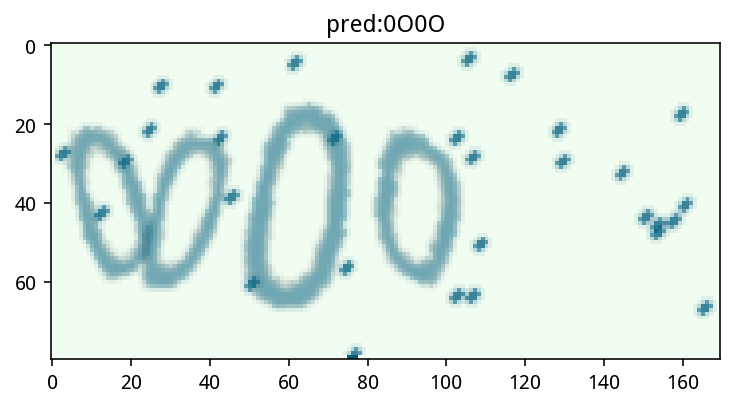

In [22]:
characters2 = characters + ' '

generator = ImageCaptcha(width=width, height=height)
random_str = '0O0O'
X_test = np.array(generator.generate_image(random_str))
X_test = X_test.transpose(1, 0, 2)
X_test = np.expand_dims(X_test, 0)

y_pred = base_model.predict(X_test)
shape = y_pred[:,2:,:].shape
ctc_decode = K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0]
out = K.get_value(ctc_decode)[:, :4]
out = ''.join([characters[x] for x in out[0]])

plt.imshow(X_test[0].transpose(1, 0, 2))
plt.title('pred:' + str(out))

argmax = np.argmax(y_pred, axis=2)[0]
list(zip(argmax, ''.join([characters2[x] for x in argmax])))